In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

database = ("../data/sql/database.sqlite")
conn = sqlite3.connect(database)
# https://www.kaggle.com/hhs/health-insurance-marketplace
# https://www.kaggle.com/shelars1985/exploring-health-insurance-marketplace

Let's start our journey by analyzing how plan rates and benefits vary across states?

### Benefits

In [2]:
query = 'SELECT * FROM BenefitsCostSharing LIMIT 10;'
BCS_df = pd.read_sql(query, conn)
BCS_df

,BenefitName,BusinessYear,CoinsInnTier1,CoinsInnTier2,CoinsOutofNet,CopayInnTier1,CopayInnTier2,CopayOutofNet,EHBVarReason,Exclusions,...,LimitUnit,MinimumStay,PlanId,QuantLimitOnSvc,RowNumber,SourceName,StandardComponentId,StateCode,StateCode2,VersionNum
0,Routine Dental Services (Adult),2014,20%,,20%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-00,Yes,68,HIOS,21989AK0010001,AK,AK,6
1,Dental Check-Up for Children,2014,20%,,20%,No Charge,,No Charge,Substantially Equal,,...,Visit(s) per 6 Months,,21989AK0010001-00,Yes,104,HIOS,21989AK0010001,AK,AK,6
2,Basic Dental Care - Child,2014,40%,,40%,No Charge,,No Charge,Substantially Equal,,...,,,21989AK0010001-00,,110,HIOS,21989AK0010001,AK,AK,6
3,Orthodontia - Child,2014,50%,,50%,No Charge,,No Charge,Additional EHB Benefit,,...,,,21989AK0010001-00,,111,HIOS,21989AK0010001,AK,AK,6
4,Major Dental Care - Child,2014,50%,,50%,No Charge,,No Charge,Substantially Equal,,...,,,21989AK0010001-00,,112,HIOS,21989AK0010001,AK,AK,6
5,Basic Dental Care - Adult,2014,40%,,40%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-00,Yes,113,HIOS,21989AK0010001,AK,AK,6
6,Orthodontia - Adult,2014,,,,,,,,,...,,,21989AK0010001-00,,114,HIOS,21989AK0010001,AK,AK,6
7,Major Dental Care - Adult,2014,50%,,50%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-00,Yes,115,HIOS,21989AK0010001,AK,AK,6
8,Accidental Dental,2014,,,,,,,,,...,,,21989AK0010001-00,,118,HIOS,21989AK0010001,AK,AK,6
9,Routine Dental Services (Adult),2014,20%,,20%,No Charge,,No Charge,Above EHB,,...,Dollars per Year,,21989AK0010001-01,Yes,68,HIOS,21989AK0010001,AK,AK,6


Lets find columns with null values.

In [3]:
benefit_count_df = pd.DataFrame(columns=['BenefitName', 'BenefitsCount'])
for c in BCS_df.columns:
    query = """SELECT BenefitName, COUNT({}) AS BenefitsCount
               FROM BenefitsCostSharing 
               WHERE {} = '';""".format(c, c)
    q = pd.read_sql(query, conn)
    q['BenefitName'].replace(np.nan, c, inplace=True)
    benefit_count_df = pd.concat([benefit_count_df, q])

benefit_count_df.reset_index(drop=True, inplace=True)
benefit_count_df

,BenefitName,BenefitsCount
0,BenefitName,0
0,BusinessYear,0
0,Orthodontia - Adult,1113847
0,Routine Dental Services (Adult),4571587
0,Orthodontia - Adult,1113847
0,Orthodontia - Adult,1113847
0,Routine Dental Services (Adult),4571587
0,Orthodontia - Adult,1113849
0,Orthodontia - Adult,3020737
0,Routine Dental Services (Adult),4572247


How many records do we have in our dataset?

In [4]:
query = '''SELECT COUNT(*) AS TotalRecords
           FROM BenefitsCostSharing'''

pd.read_sql(query, conn)

,TotalRecords
0,5048408


How many unique benefits do we have in our dataset?

In [5]:
query = """SELECT COUNT (DISTINCT BenefitName) AS UniqueBenefits
           FROM BenefitsCostSharing
           """
pd.read_sql(query, conn)

,UniqueBenefits
0,861


What is the most popular benefit each year?

In [6]:
query = """SELECT year, name
           FROM (SELECT BusinessYear as year, Benefitname as name, COUNT(*),
                        ROW_NUMBER() OVER (PARTITION BY BusinessYear 
                                           ORDER BY COUNT(*) DESC) as rn
                 FROM BenefitsCostSharing
                 GROUP BY BusinessYear, Benefitname
                 ) as t
           WHERE rn = 1;"""

pd.read_sql(query, conn)

,year,name
0,2014,Routine Dental Services (Adult)
1,2015,Orthodontia - Adult
2,2016,Orthodontia - Adult


How many benifits did each year have?

In [7]:
query = """SELECT BusinessYear, COUNT(BenefitName) AS BenefitCount, COUNT(DISTINCT BenefitName) AS UniqueBenefit
           FROM BenefitsCostSharing
           GROUP BY BusinessYear"""

pd.read_sql(query, conn)

,BusinessYear,BenefitCount,UniqueBenefit
0,2014,1164869,496
1,2015,2079286,517
2,2016,1804253,429


What are the top 10 Benifits for 2014, 2015, and 2016

In [19]:
query = """SELECT BenefitName, COUNT(*) AS frequency
           FROM BenefitsCostSharing
           WHERE BusinessYear = 2014
           GROUP BY BenefitName
           ORDER BY COUNT(*) DESC, BenefitName
           LIMIT 10"""

pd.read_sql(query, conn)

,BenefitName,frequency
0,Accidental Dental,18719
1,Basic Dental Care - Adult,18719
2,Basic Dental Care - Child,18719
3,Dental Check-Up for Children,18719
4,Major Dental Care - Adult,18719
5,Major Dental Care - Child,18719
6,Orthodontia - Adult,18719
7,Orthodontia - Child,18719
8,Routine Dental Services (Adult),18719
9,Abortion for Which Public Funding is Prohibited,15187


In [9]:
query = """SELECT BenefitName, COUNT(*) AS frequency
           FROM BenefitsCostSharing
           WHERE BusinessYear = 2015
           GROUP BY BenefitName
           ORDER BY COUNT(*) DESC, BenefitName
           LIMIT 10"""

pd.read_sql(query, conn)

,BenefitName,frequency
0,Orthodontia - Adult,31269
1,Accidental Dental,31253
2,Basic Dental Care - Adult,31253
3,Basic Dental Care - Child,31253
4,Dental Check-Up for Children,31253
5,Major Dental Care - Adult,31253
6,Major Dental Care - Child,31253
7,Routine Dental Services (Adult),31253
8,Orthodontia - Child,31245
9,Treatment for Temporomandibular Joint Disorders,26993


In [10]:
query = """SELECT BenefitName, COUNT(*) AS frequency
           FROM BenefitsCostSharing
           WHERE BusinessYear = 2016
           GROUP BY BenefitName
           ORDER BY COUNT(*) DESC, BenefitName
           LIMIT 10"""

pd.read_sql(query, conn)

,BenefitName,frequency
0,Orthodontia - Adult,27389
1,Accidental Dental,27381
2,Basic Dental Care - Adult,27381
3,Basic Dental Care - Child,27381
4,Dental Check-Up for Children,27381
5,Major Dental Care - Adult,27381
6,Major Dental Care - Child,27381
7,Orthodontia - Child,27381
8,Routine Dental Services (Adult),27381
9,Treatment for Temporomandibular Joint Disorders,23544


How many states do we have data from?

In [22]:
query = """SELECT COUNT(DISTINCT StateCode) AS NumberOfStates
           FROM BenefitsCostSharing"""

pd.read_sql(query, conn)

,NumberOfStates
0,39


How many Benifits does each state have?

In [11]:
query = """SELECT StateCode AS State, COUNT(BenefitName) AS NumBenefits
           FROM BenefitsCostSharing
           GROUP BY StateCode
           ORDER BY StateCode;"""

pd.read_sql(query, conn)

,State,NumBenefits
0,AK,41320
1,AL,28417
2,AR,68064
3,AZ,221612
4,DE,31370
5,FL,364742
6,GA,196579
7,HI,6741
8,IA,110221
9,ID,27313


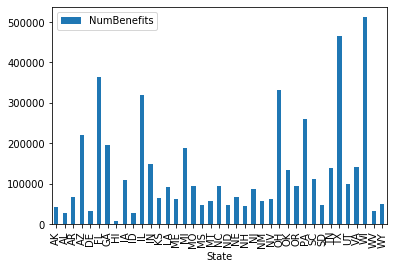

In [12]:
state_df.plot(kind='bar', x='State')

What is the most popular Benifit in each State?

In [13]:
query = """SELECT State, name
           FROM (SELECT StateCode AS State, Benefitname as name, COUNT(*),
                        ROW_NUMBER() OVER (PARTITION BY StateCode 
                                           ORDER BY COUNT(*) DESC) as rn
                 FROM BenefitsCostSharing
                 GROUP BY StateCode, Benefitname
                 ) t
           WHERE rn = 1;"""

pd.read_sql(query, conn)

,State,name
0,AK,Routine Dental Services (Adult)
1,AL,Routine Dental Services (Adult)
2,AR,Orthodontia - Adult
3,AZ,Routine Dental Services (Adult)
4,DE,Routine Dental Services (Adult)
5,FL,Routine Dental Services (Adult)
6,GA,Routine Dental Services (Adult)
7,HI,Routine Dental Services (Adult)
8,IA,Routine Dental Services (Adult)
9,ID,Routine Dental Services (Adult)


### Rates

In [27]:
query = """SELECT * FROM Rate LIMIT 10"""

pd.read_sql(query, conn)

,BusinessYear,StateCode,IssuerId,SourceName,VersionNum,ImportDate,IssuerId2,FederalTIN,RateEffectiveDate,RateExpirationDate,...,IndividualRate,IndividualTobaccoRate,Couple,PrimarySubscriberAndOneDependent,PrimarySubscriberAndTwoDependents,PrimarySubscriberAndThreeOrMoreDependents,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents,RowNumber
0,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,29.00,,,,,,,,,14
1,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,36.95,,73.9,107.61,107.61,107.61,144.56,144.56,144.56,14
2,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,36.95,,73.9,107.61,107.61,107.61,144.56,144.56,144.56,15
3,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,32.00,,,,,,,,,15
4,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,32.00,,,,,,,,,16
5,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,36.95,,73.9,107.61,107.61,107.61,144.56,144.56,144.56,16
6,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,32.45,,64.9,94.5,94.5,94.5,126.95,126.95,126.95,17
7,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,32.00,,,,,,,,,17
8,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,32.00,,,,,,,,,18
9,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,32.45,,64.9,94.5,94.5,94.5,126.95,126.95,126.95,18


How much is the most expensive Individual Plans in each state?

In [105]:
query = """SELECT StateCode, 
                  MAX(PrimarySubscriberAndOneDependent) AS PriOneDependent,
                  MAX(PrimarySubscriberAndTwoDependents)AS PriTwoDependent,
                  MAX(PrimarySubscriberAndThreeOrMoreDependents) AS PriThreeDependent,
                  MAX(Couple) AS Couple,
                  MAX(CoupleAndOneDependent) AS CoOneDependent,
                  MAX(CoupleAndTwoDependents) AS CoTwoDependents,
                  MAX(CoupleAndThreeOrMoreDependents) AS CoThreeOrMoreDependents
           FROM Rate
           WHERE Age = 'Family Option'
           GROUP BY StateCode"""

family_opiton_df = pd.read_sql(query, conn)

In [108]:
query = """SELECT StateCode, MAX(IndividualRate)
           FROM Rate
           GROUP BY StateCode"""

inividual_rate_df = pd.read_sql(query, conn)

In [109]:
query = """SELECT StateCode, MAX(IndividualTobaccoRate)
           FROM Rate
           WHERE Tobacco = 'Tobacco User/Non-Tobacco User'
           GROUP BY StateCode"""

individual_tobacco_df = pd.read_sql(query, conn)

Having a plan that is 999,999.00 or 9,999.00 is a weird price.  Lets look at the 10 ten rates in the state of Utah to look more into this.

In [80]:
query = """SELECT DISTINCT PrimarySubscriberAndOneDependent
           FROM Rate
           WHERE StateCode = 'UT'
           ORDER BY IndividualRate DESC"""

pd.read_sql(query, conn)

,PrimarySubscriberAndOneDependent
0,95.03
1,92.38
2,91.89
3,90.88
4,89.46
5,88.01
6,75.62
7,103.77
8,75.32
9,103.37


Lets look at the stats of the Individual Rates but take out the outliers of anything over 9999.

In [69]:
query = """SELECT StateCode, MIN(IndividualRate) AS Minimum, 
                  MAX(IndividualRate) AS Maximum, 
                  ROUND(AVG(IndividualRate), 2) AS Average
           FROM Rate
           WHERE IndividualRate > 0 AND IndividualRate < 9999
           GROUP BY StateCode"""

IndividualRate_stats_df = pd.read_sql(query, conn)

In [57]:
query = """SELECT StateCode, --string_list, count, middle,
                CASE WHEN count%2=0 THEN
                    0.5 * substr(string_list, middle-10, 10) + 0.5 * substr(string_list, middle, 10)
                ELSE
                    1.0 * substr(string_list, middle, 10)
                END AS median
           FROM (SELECT StateCode, 
                    group_concat(value_string,"") AS string_list,
                    count() AS count, 
                    1 + 10*(count()/2) AS middle
                 FROM (SELECT StateCode, 
                            printf( '%010d',IndividualRate) AS value_string
                       FROM Rate
                       ORDER BY StateCode,value_string
                      )
                 GROUP BY StateCode
                )"""

IndividualRate_median_df = pd.read_sql(query, conn)

In [70]:
IndividualRate_stats_merged_df = pd.merge(stats_df, median_df)

In [71]:
IndividualRate_stats_merged_df

,StateCode,Minimum,Maximum,Average,median
0,AK,25.84,2421.00,673.12,577.0
1,AL,8.34,1574.19,273.53,190.0
2,AR,3.93,1268.28,241.28,131.0
3,AZ,9.23,1758.61,367.85,316.0
4,DE,13.95,1387.23,399.78,341.0
5,FL,6.60,2046.51,276.91,219.0
6,GA,1.50,1806.58,302.00,232.0
7,HI,15.89,1024.29,264.17,242.5
8,IA,10.50,1340.43,333.82,296.0
9,ID,19.31,1137.00,335.59,297.0


In [14]:
conn.close()